# Working with filing data from the SEC's EDGAR service

In [1]:
import warnings
warnings.filterwarnings('ignore')

In [2]:
%matplotlib inline

from pathlib import Path
from datetime import date
import json
from io import BytesIO
from zipfile import ZipFile, BadZipFile
import requests

import pandas_datareader.data as web
import pandas as pd

from pprint import pprint

import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker

In [3]:
sns.set_style('whitegrid')

In [4]:
data_path = Path('data') # perhaps set to external harddrive to accomodate large amount of data
if not data_path.exists():
    data_path.mkdir()

## Download FS & Notes

The following code downloads and extracts all historical filings contained in the [Financial Statement and Notes](https://www.sec.gov/dera/data/financial-statement-and-notes-data-set.html) (FSN) datasets for the given range of quarters:

**Downloads over 40GB of data!**

In [5]:
SEC_URL = 'https://www.sec.gov/'
FSN_PATH = 'files/dera/data/financial-statement-and-notes-data-sets/'

In [6]:
today = pd.Timestamp(date.today())
this_year = today.year
this_quarter = today.quarter
# FRK: changed 2014 -> 2005
past_years = range(2009, this_year)

In [7]:
filing_periods = [(y, q) for y in past_years for q in range(1, 5)]
filing_periods.extend([(this_year, q) for q in range(1, this_quarter + 1)])

In [8]:
# FRK: added cell to see what is stored in filing_periods
filing_periods

[(2005, 1),
 (2005, 2),
 (2005, 3),
 (2005, 4),
 (2006, 1),
 (2006, 2),
 (2006, 3),
 (2006, 4),
 (2007, 1),
 (2007, 2),
 (2007, 3),
 (2007, 4),
 (2008, 1),
 (2008, 2),
 (2008, 3),
 (2008, 4),
 (2009, 1),
 (2009, 2),
 (2009, 3),
 (2009, 4),
 (2010, 1),
 (2010, 2),
 (2010, 3),
 (2010, 4),
 (2011, 1),
 (2011, 2),
 (2011, 3),
 (2011, 4),
 (2012, 1),
 (2012, 2),
 (2012, 3),
 (2012, 4),
 (2013, 1),
 (2013, 2),
 (2013, 3),
 (2013, 4),
 (2014, 1),
 (2014, 2),
 (2014, 3),
 (2014, 4),
 (2015, 1),
 (2015, 2),
 (2015, 3),
 (2015, 4),
 (2016, 1),
 (2016, 2),
 (2016, 3),
 (2016, 4),
 (2017, 1),
 (2017, 2),
 (2017, 3),
 (2017, 4),
 (2018, 1),
 (2018, 2),
 (2018, 3),
 (2018, 4),
 (2019, 1),
 (2019, 2),
 (2019, 3),
 (2019, 4),
 (2020, 1),
 (2020, 2),
 (2020, 3),
 (2020, 4),
 (2021, 1)]

In [9]:
for i, (yr, qtr) in enumerate(filing_periods, 1):
    print(i, yr, qtr)
    
    print(f'{yr}-Q{qtr}', end=' ', flush=True)
    filing = f'{yr}q{qtr}_notes.zip'
    path = data_path / f'{yr}_{qtr}' / 'source'
    print(path)
    
    if not path.exists():
        path.mkdir(exist_ok=True, parents=True)
    # FRK: FSN -> FSN_PATH
    url = SEC_URL + FSN_PATH + filing
    
    # 2020q1 is currently (Oct 2020) in a different location; this may change at some point
    
    # FRK: commented this out as it does not seem to be needed. Did need to change year -> yr and
    # q -> qtr as well
#     if yr == 2020 and qtr == 1:
#         url = SEC_URL + 'files/node/add/data_distribution/' + filing
    
    # FRK: had to add url argument to get()
    response = requests.get(url).content
    
    try:
        with ZipFile(BytesIO(response)) as zip_file:
            for file in zip_file.namelist():
                local_file = path / file
                if local_file.exists():
                    continue
                with local_file.open('wb') as output:
                    for line in zip_file.open(file).readlines():
                        output.write(line)
    except BadZipFile:
        'https://www.sec.gov/files/node/add/data_distribution/2020q1_notes.zip'
        print('got bad zip file')
        continue

1 2005 1
2005-Q1 data/2005_1/source
got bad zip file
2 2005 2
2005-Q2 data/2005_2/source
got bad zip file
3 2005 3
2005-Q3 data/2005_3/source
got bad zip file
4 2005 4
2005-Q4 data/2005_4/source
got bad zip file
5 2006 1
2006-Q1 data/2006_1/source
got bad zip file
6 2006 2
2006-Q2 data/2006_2/source
got bad zip file
7 2006 3
2006-Q3 data/2006_3/source
got bad zip file
8 2006 4
2006-Q4 data/2006_4/source
got bad zip file
9 2007 1
2007-Q1 data/2007_1/source
got bad zip file
10 2007 2
2007-Q2 data/2007_2/source
got bad zip file
11 2007 3
2007-Q3 data/2007_3/source
got bad zip file
12 2007 4
2007-Q4 data/2007_4/source
got bad zip file
13 2008 1
2008-Q1 data/2008_1/source
got bad zip file
14 2008 2
2008-Q2 data/2008_2/source
got bad zip file
15 2008 3
2008-Q3 data/2008_3/source
got bad zip file
16 2008 4
2008-Q4 data/2008_4/source
got bad zip file
17 2009 1
2009-Q1 data/2009_1/source
18 2009 2
2009-Q2 data/2009_2/source
19 2009 3
2009-Q3 data/2009_3/source
20 2009 4
2009-Q4 data/2009_4/sour

## Save to parquet

The data is fairly large and to enable faster access than the original text files permit, it is better to convert the text files to binary, columnar parquet format (see Section 'Efficient data storage with pandas' in chapter 2 for a performance comparison of various data-storage options compatible with pandas DataFrames):

In [11]:
# check what the for loop is doing. Added cell.
for f in sorted(data_path.glob('**/*.tsv')):
    print(f)

data/2009_1/source/cal.tsv
data/2009_1/source/dim.tsv
data/2009_1/source/num.tsv
data/2009_1/source/pre.tsv
data/2009_1/source/ren.tsv
data/2009_1/source/sub.tsv
data/2009_1/source/tag.tsv
data/2009_1/source/txt.tsv
data/2009_2/source/cal.tsv
data/2009_2/source/dim.tsv
data/2009_2/source/num.tsv
data/2009_2/source/pre.tsv
data/2009_2/source/ren.tsv
data/2009_2/source/sub.tsv
data/2009_2/source/tag.tsv
data/2009_2/source/txt.tsv
data/2009_3/source/cal.tsv
data/2009_3/source/dim.tsv
data/2009_3/source/num.tsv
data/2009_3/source/pre.tsv
data/2009_3/source/ren.tsv
data/2009_3/source/sub.tsv
data/2009_3/source/tag.tsv
data/2009_3/source/txt.tsv
data/2009_4/source/cal.tsv
data/2009_4/source/dim.tsv
data/2009_4/source/num.tsv
data/2009_4/source/pre.tsv
data/2009_4/source/ren.tsv
data/2009_4/source/sub.tsv
data/2009_4/source/tag.tsv
data/2009_4/source/txt.tsv
data/2010_1/source/cal.tsv
data/2010_1/source/dim.tsv
data/2010_1/source/num.tsv
data/2010_1/source/pre.tsv
data/2010_1/source/ren.tsv
d

In [12]:
# FRK: added sorted() tot for loop
for f in sorted(data_path.glob('**/*.tsv')):
    file_name = f.stem  + '.parquet'
    path = Path(f.parents[1]) / 'parquet'
    if (path / file_name).exists():
        continue
    if not path.exists():
        path.mkdir(exist_ok=True)
    try:
        df = pd.read_csv(f, sep='\t', encoding='latin1', low_memory=False)
    except:
        print(f)
    df.to_parquet(path / file_name, engine='pyarrow' )

data/2009_2/source/txt.tsv
data/2009_3/source/txt.tsv
data/2009_4/source/txt.tsv
data/2010_1/source/txt.tsv
data/2010_2/source/txt.tsv
data/2010_3/source/txt.tsv
data/2010_4/source/txt.tsv
data/2011_1/source/tag.tsv
data/2011_3/source/tag.tsv
data/2011_3/source/txt.tsv
data/2012_1/source/txt.tsv
data/2012_2/source/tag.tsv
data/2012_2/source/txt.tsv
data/2012_3/source/tag.tsv
data/2012_3/source/txt.tsv
data/2012_4/source/txt.tsv
data/2013_1/source/tag.tsv
data/2013_1/source/txt.tsv
data/2013_2/source/txt.tsv
data/2013_3/source/txt.tsv
data/2013_4/source/txt.tsv


## Metadata json

In [13]:
file = data_path / '2018_3' / 'source' / '2018q3_notes-metadata.json'
with file.open() as f:
    data = json.load(f)

pprint(data)

{'@context': 'http://www.w3.org/ns/csvw',
 'dialect': {'delimiter': '\t', 'header': True, 'headerRowCount': 1},
 'tables': [{'tableSchema': {'aboutUrl': 'readme.htm',
                             'columns': [{'datatype': {'base': 'string',
                                                       'maxLength': 20,
                                                       'minLength': 20},
                                          'dc:description': 'Accession Number. '
                                                            'The 20-character '
                                                            'string formed '
                                                            'from the 18-digit '
                                                            'number assigned '
                                                            'by the Commission '
                                                            'to each EDGAR '
                                                           

                                          'required': 'true',
                                          'titles': ['Accession number']},
                                         {'datatype': {'base': 'string',
                                                       'maxLength': 255},
                                          'dc:description': 'The unique '
                                                            'identifier (name) '
                                                            'for a tag in a '
                                                            'specific taxonomy '
                                                            'release.',
                                          'name': 'tag',
                                          'required': 'true',
                                          'titles': ['Localname']},
                                         {'datatype': {'base': 'string',
                                                       'maxLength': 20

## Data Organization

For each quarter, the FSN data is organized into eight file sets that contain information about submissions, numbers, taxonomy tags, presentation, and more. Each dataset consists of rows and fields and is provided as a tab-delimited text file:

| File | Dataset      | Description                                                 |
|------|--------------|-------------------------------------------------------------|
| SUB  | Submission   | Identifies each XBRL submission by company, form, date, etc |
| TAG  | Tag          | Defines and explains each taxonomy tag                      |
| DIM  | Dimension    | Adds detail to numeric and plain text data                  |
| NUM  | Numeric      | One row for each distinct data point in filing              |
| TXT  | Plain Text   | Contains all non-numeric XBRL fields                        |
| REN  | Rendering    | Information for rendering on SEC website                    |
| PRE  | Presentation | Detail on tag and number presentation in primary statements |
| CAL  | Calculation  | Shows arithmetic relationships among tags                   |

## Submission Data

The latest submission file contains around 6,500 entries (2018, 3rd quarter).

In [14]:
sub1 = pd.read_parquet(data_path / '2018_3' / 'parquet' / 'sub.parquet')
sub1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6493 entries, 0 to 6492
Data columns (total 40 columns):
adsh           6493 non-null object
cik            6493 non-null int64
name           6493 non-null object
sic            6492 non-null float64
countryba      6482 non-null object
stprba         5900 non-null object
cityba         6482 non-null object
zipba          6478 non-null object
bas1           6482 non-null object
bas2           2804 non-null object
baph           6482 non-null object
countryma      6448 non-null object
stprma         5906 non-null object
cityma         6448 non-null object
zipma          6447 non-null object
mas1           6448 non-null object
mas2           2761 non-null object
countryinc     5936 non-null object
stprinc        5632 non-null object
ein            6492 non-null float64
former         3618 non-null object
changed        3618 non-null float64
afs            6480 non-null object
wksi           6493 non-null int64
fye            6490 non-null

In [16]:
sub2 = pd.read_parquet(data_path / '2020_4' / 'parquet' / 'sub.parquet')
sub2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16113 entries, 0 to 16112
Data columns (total 40 columns):
adsh           16113 non-null object
cik            16113 non-null int64
name           16113 non-null object
sic            16109 non-null float64
countryba      16086 non-null object
stprba         15162 non-null object
cityba         16086 non-null object
zipba          16077 non-null object
bas1           16086 non-null object
bas2           6684 non-null object
baph           16096 non-null object
countryma      16027 non-null object
stprma         15181 non-null object
cityma         16028 non-null object
zipma          16016 non-null object
mas1           16021 non-null object
mas2           6594 non-null object
countryinc     14696 non-null object
stprinc        13979 non-null object
ein            16110 non-null float64
former         9227 non-null object
changed        9227 non-null float64
afs            16048 non-null object
wksi           16113 non-null int64
fye   

### Get AAPL submission

The submission dataset contains the unique identifiers required to retrieve the filings: the Central Index Key (CIK) and the Accession Number (adsh). The following shows some of the information about Apple's 2018Q1 10-Q filing:

In [17]:
# FRK: for now point sub to sub1
sub = sub2
name = 'APPLE INC'
apple = sub[sub.name == name].T.dropna().squeeze()
key_cols = ['name', 'adsh', 'cik', 'name', 'sic', 'countryba', 'stprba',
            'cityba', 'zipba', 'bas1', 'form', 'period', 'fy', 'fp', 'filed']
apple.loc[key_cols]

,3645,4361
name,APPLE INC,APPLE INC
adsh,0000320193-20-000094,0000320193-20-000096
cik,320193,320193
name,APPLE INC,APPLE INC
sic,3571,3571
countryba,US,US
stprba,CA,CA
cityba,CUPERTINO,CUPERTINO
zipba,95014,95014
bas1,ONE APPLE PARK WAY,ONE APPLE PARK WAY


In [18]:
# FRK: play with sub dataframe. Note that it returns two rows. 
# The old notebook assumes it does return only one row.
# differences: adsh, form, period, filed, accepted, 
sub[sub.name=='APPLE INC'].T.dropna().squeeze()

,3645,4361
adsh,0000320193-20-000094,0000320193-20-000096
cik,320193,320193
name,APPLE INC,APPLE INC
sic,3571,3571
countryba,US,US
stprba,CA,CA
cityba,CUPERTINO,CUPERTINO
zipba,95014,95014
bas1,ONE APPLE PARK WAY,ONE APPLE PARK WAY
baph,(408) 996-1010,(408) 996-1010


## Build AAPL fundamentals dataset

Using the central index key, we can identify all historical quarterly filings available for Apple, and combine this information to obtain 26 Forms 10-Q and nine annual Forms 10-K.

### Get filings

In [19]:
apple.T.cik

3645    320193
4361    320193
Name: cik, dtype: object

In [20]:
apple.T.cik.unique()

array([320193], dtype=object)

In [21]:
sub.form

0           8-K
1           8-K
2          10-Q
3           8-K
4           8-K
          ...  
16108      10-Q
16109    10-Q/A
16110       S-1
16111       8-K
16112       8-K
Name: form, Length: 16113, dtype: object

In [22]:
sum(sub.cik.isin(list(apple.T.cik.unique())))

2

In [23]:
sub.form.isin(['10-Q', '10-K'])

0        False
1        False
2         True
3        False
4        False
         ...  
16108     True
16109    False
16110    False
16111    False
16112    False
Name: form, Length: 16113, dtype: bool

In [24]:
aapl_subs = pd.DataFrame()
for sub in data_path.glob('**/sub.parquet'):
    sub = pd.read_parquet(sub)
    # FRK changed to (sub.cik.astype(int) == apple.cik) --> sub.cik.isin(list(apple.T.cik))
    # change needed as apple.cik can be multiple and hence we need to use apple.T.cik
    # code also works when apple only contains a series of scalars
    aapl_sub = sub[(sub.cik.isin(list(apple.T.cik.unique()))) & (sub.form.isin(['10-Q', '10-K']))]
    aapl_subs = pd.concat([aapl_subs, aapl_sub])

We find 15 quarterly 10-Q and 4 annual 10-K reports:

In [25]:
aapl_subs.form.value_counts()

10-Q    34
10-K    12
Name: form, dtype: int64

### Get numerical filing data

With the Accession Number for each filing, we can now rely on the taxonomies to select the appropriate XBRL tags (listed in the TAG file) from the NUM and TXT files to obtain the numerical or textual/footnote data points of interest.

First, let's extract all numerical data available from the 19 Apple filings:

In [26]:
aapl_subs

,adsh,cik,name,sic,countryba,stprba,cityba,zipba,bas1,bas2,...,accepted,prevrpt,detail,instance,nciks,aciks,pubfloatusd,floatdate,floataxis,floatmems
565,0001193125-15-023697,320193,APPLE INC,3571.0,US,CA,CUPERTINO,95014,ONE INFINITE LOOP,None,...,2015-01-28 16:40:00.0,0,1,aapl-20141227.xml,1,None,NaN,NaN,None,NaN
2032,0001628280-17-004790,320193,APPLE INC,3571.0,US,CA,CUPERTINO,95014,ONE INFINITE LOOP,None,...,2017-05-03 16:32:00.0,0,1,aapl-20170401.xml,1,None,NaN,NaN,None,NaN
1195,0000320193-19-000076,320193,APPLE INC,3571.0,US,CA,CUPERTINO,95014,ONE APPLE PARK WAY,None,...,2019-07-31 16:32:00.0,0,1,a10-qq320196292019_htm.xml,1,None,NaN,NaN,NaN,NaN
3210,0000320193-19-000119,320193,APPLE INC,3571.0,US,CA,CUPERTINO,95014,ONE APPLE PARK WAY,None,...,2019-10-30 18:13:00.0,0,1,a10-k20199282019_htm.xml,1,None,8.746980e+11,20190329.0,None,NaN
708,0001193125-13-300670,320193,APPLE INC,3571.0,US,CA,CUPERTINO,95014,ONE INFINITE LOOP,None,...,2013-07-24 17:02:00.0,0,1,aapl-20130629.xml,1,None,NaN,NaN,None,NaN
1158,0001193125-13-416534,320193,APPLE INC,3571.0,US,CA,CUPERTINO,95014,ONE INFINITE LOOP,None,...,2013-10-29 20:38:00.0,0,1,aapl-20130928.xml,1,None,4.160050e+11,20130329.0,None,NaN
1197,0000320193-17-000009,320193,APPLE INC,3571.0,US,CA,CUPERTINO,95014,ONE INFINITE LOOP,None,...,2017-08-02 16:31:00.0,0,1,aapl-20170701.xml,1,None,NaN,NaN,None,NaN
1821,0000320193-17-000070,320193,APPLE INC,3571.0,US,CA,CUPERTINO,95014,ONE INFINITE LOOP,None,...,2017-11-03 08:02:00.0,0,1,aapl-20170930.xml,1,None,7.475090e+11,20170331.0,None,NaN
1743,0001193125-13-168288,320193,APPLE INC,3571.0,US,CA,CUPERTINO,95014,ONE INFINITE LOOP,None,...,2013-04-23 21:29:00.0,0,1,aapl-20130330.xml,1,None,NaN,NaN,None,NaN
44,0001193125-11-010144,320193,APPLE INC,3571.0,US,CA,CUPERTINO,95014,ONE INFINITE LOOP,None,...,2011-01-19 16:33:00.0,0,1,aapl-20101225.xml,1,None,NaN,NaN,None,NaN


In [27]:
aapl_subs.adsh

565     0001193125-15-023697
2032    0001628280-17-004790
1195    0000320193-19-000076
3210    0000320193-19-000119
708     0001193125-13-300670
1158    0001193125-13-416534
1197    0000320193-17-000009
1821    0000320193-17-000070
1743    0001193125-13-168288
44      0001193125-11-010144
1909    0000320193-19-000066
1934    0000320193-20-000010
5       0001193125-09-153165
67      0001193125-09-214859
27      0001193125-10-162840
167     0001193125-10-238044
481     0001193125-16-439878
1281    0001193125-14-157311
610     0000320193-18-000007
16      0001193125-10-088957
504     0001193125-12-023398
582     0001193125-14-277160
775     0001193125-14-383437
521     0001193125-11-282113
63      0001193125-11-192493
1356    0001193125-15-153166
590     0001628280-17-000717
563     0001193125-13-022339
86      0001193125-11-104388
373     0000320193-19-000010
796     0001193125-15-356351
515     0001193125-15-259935
4165    0000320193-20-000062
4361    0000320193-20-000096
4205    000032

In [28]:
aapl_nums = pd.DataFrame()
for num in data_path.glob('**/num.parquet'):
    num = pd.read_parquet(num).drop('dimh', axis=1)
    aapl_num = num[num.adsh.isin(aapl_subs.adsh)]
    print(len(aapl_num))
    aapl_nums = pd.concat([aapl_nums, aapl_num])
aapl_nums.ddate = pd.to_datetime(aapl_nums.ddate, format='%Y%m%d')   
aapl_nums.to_parquet(data_path / 'aapl_nums.parquet')


# FRK: added to see total # of rows in aapl_nums
print(f"Total rows in aapl_nums: {len(aapl_nums)}")

751
951
1039
1176
767
1151
1001
1364
703
602
1035
0
784
178
262
859
1291
707
805
793
176
525
919
1271
1068
669
942
738
557
644
755
1345
961
1028
0
1223
1017
905
682
1032
645
1224
937
1277
923
952
145
647
Total rows in aapl_nums: 39426


In [29]:
# FRK: added to see how many unique tags there are
len(aapl_nums.tag.unique())

786

In [30]:
# FRK: Added to see the tages that contain 'Shares' in their tag name
for t in sorted(aapl_nums.tag.unique()):
    if 'Shares' in t:
        print(t)

AdditionalStockRepurchasedAndRetiredDuringPeriodShares
CommonStockSharesAuthorized
CommonStockSharesIssued
CommonStockSharesOutstanding
CumulativeStockRepurchasedAndRetiredShares
EntityCommonStockSharesOutstanding
EquityInstrumentsOtherThanOptionsSharesNetShareSettledToCoverWithholdingTaxes
FactorByWhichEachRSUGrantedReducesAndEachRSUCanceledOrShareWithheldForTaxesIncreasesSharesAvailableForGrant
FactorByWhichEachRSUGrantedReducesOrEachRSUCanceledOrShareWithheldForTaxesIncreasesSharesAvailableForGrant
PreferredStockSharesAuthorized
RemainingStockRepurchasedAndRetiredDuringSubsequentPeriodShares
Share-BasedCompensationArrangementByShareBasedPaymentAwardOptionsAvailableForGrantAdditionalSharesAuthorizedInPeriod
ShareBasedCompensationArrangementByEmployeeStockPurchasePlanNumberOfSharesAuthorized
ShareBasedCompensationArrangementByShareBasedPaymentAwardEquityInstrumentsOtherThanOptionsNumberOfSharesOfCommonStockIssuedPerUnitUponVesting
ShareBasedCompensationArrangementByShareBasedPaymentAw

In total, the nine years of filing history provide us with over 18,000 numerical values for AAPL. This comment is based upon 2014, 1st qtr - 2018, 1st qtr. It now goes up to 2020, 4th qtr. It has over 27,000 rows now.

In [31]:
aapl_nums.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 39426 entries, 4298 to 3245154
Data columns (total 15 columns):
adsh        39426 non-null object
tag         39426 non-null object
version     39426 non-null object
ddate       39426 non-null datetime64[ns]
qtrs        39426 non-null object
uom         39426 non-null object
iprx        39426 non-null float64
value       39320 non-null float64
footnote    189 non-null object
footlen     39426 non-null object
dimn        39426 non-null object
coreg       0 non-null object
durp        39426 non-null float64
datp        39426 non-null float64
dcml        39426 non-null float64
dtypes: datetime64[ns](1), float64(5), object(9)
memory usage: 4.8+ MB


## Create P/E Ratio from EPS and stock price data

We can select a useful field, such as Earnings per Diluted Share (EPS), that we can combine with market data to calculate the popular Price/Earnings (P/E) valuation ratio.

In [32]:
# stock_split = 7
# split_date = pd.to_datetime('20140604')
# split_date

We do need to take into account, however, that Apple split its stock 7:1 on June 4, 2014, and Adjusted Earnings per Share before the split to make earnings comparable, as illustrated in the following code block:

In [33]:
# FRK: added to understand different quarter values better
aapl_nums[(aapl_nums.tag == 'EarningsPerShareDiluted')].qtrs.value_counts()

1    166
4     42
3     28
2     26
Name: qtrs, dtype: int64

In [34]:
# FRK: make sure I understand what the drop() is doing. It basically drops the tag column as that is no 
# longer needed
eps = aapl_nums[(aapl_nums.tag == 'EarningsPerShareDiluted') & (aapl_nums.qtrs == 1)].drop('tag', axis=1)
eps = eps[['adsh', 'ddate', 'value']].groupby('adsh').apply(lambda x: x.nlargest(n=1, columns=['ddate']))
eps.index = eps.ddate.values
eps = eps[['ddate', 'value']]
eps = eps.sort_values(by='ddate', ascending=True)
eps, len(eps)

(                ddate  value
 2009-06-30 2009-06-30   1.35
 2009-12-31 2009-12-31   3.67
 2010-03-31 2010-03-31   3.33
 2010-06-30 2010-06-30   3.51
 2010-09-30 2010-09-30   4.64
 2010-12-31 2010-12-31   6.43
 2011-03-31 2011-03-31   6.40
 2011-06-30 2011-06-30   7.79
 2011-09-30 2011-09-30   7.05
 2011-12-31 2011-12-31  13.87
 2012-03-31 2012-03-31  12.30
 2012-06-30 2012-06-30   9.32
 2012-09-30 2012-09-30   8.67
 2012-12-31 2012-12-31  13.81
 2013-03-31 2013-03-31  10.09
 2013-06-30 2013-06-30   7.47
 2013-09-30 2013-09-30   8.26
 2013-12-31 2013-12-31  14.50
 2014-03-31 2014-03-31  11.62
 2014-06-30 2014-06-30   1.28
 2014-09-30 2014-09-30   1.42
 2014-12-31 2014-12-31   3.06
 2015-03-31 2015-03-31   2.33
 2015-06-30 2015-06-30   1.85
 2015-09-30 2015-09-30   1.96
 2015-12-31 2015-12-31   3.28
 2016-03-31 2016-03-31   1.90
 2016-06-30 2016-06-30   1.42
 2016-09-30 2016-09-30   1.67
 2016-12-31 2016-12-31   3.36
 2017-03-31 2017-03-31   2.10
 2017-06-30 2017-06-30   1.67
 2017-09-3

In [35]:
# # Filter by tag; keep only values measuring 1 quarter
# eps = aapl_nums[(aapl_nums.tag == 'EarningsPerShareDiluted')
#                 & (aapl_nums.qtrs == 1)].drop('tag', axis=1)

# # Keep only most recent data point from each filing
# eps = eps.groupby('adsh').apply(lambda x: x.nlargest(n=1, columns=['ddate']))

# # Adjust earnings prior to stock split downward
# # FRK: change div(7) -> div(stock_split)
# # eps.loc[eps.ddate < split_date,'value'] = eps.loc[eps.ddate < split_date, 'value'].div(stock_split)
# # eps = eps[['ddate', 'value']].set_index('ddate').squeeze().sort_index()
# # eps = eps.rolling(4,min_periods=4).sum().dropna()

In [36]:
# eps['value'].plot(lw=2, figsize=(14, 6), title='Diluted Earnings per Share')
# plt.xlabel('')
# plt.savefig('diluted eps', dps=300);

In [37]:
symbol = 'AAPL'
import yfinance as yf
aapl_stock =yf.Ticker(symbol).history(start=str(eps.index.min())[:10], end=str(eps.index.max())[:10])
aapl_stock.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2833 entries, 2009-06-30 to 2020-09-29
Data columns (total 7 columns):
Open            2833 non-null float64
High            2833 non-null float64
Low             2833 non-null float64
Close           2833 non-null float64
Volume          2833 non-null int64
Dividends       2833 non-null float64
Stock Splits    2833 non-null float64
dtypes: float64(6), int64(1)
memory usage: 177.1 KB


In [38]:
aapl_stock['Stock Splits'].value_counts()

0.0    2831
4.0       1
7.0       1
Name: Stock Splits, dtype: int64

In [39]:
splits = aapl_stock[['Stock Splits']].loc[aapl_stock['Stock Splits'] > 0]
splits['Split_Date'] = splits.index.values
splits

,Stock Splits,Split_Date
Date,,
2014-06-09,7.0,2014-06-09
2020-08-31,4.0,2020-08-31


In [40]:
# eps.loc[eps.ddate < split_date,'value'] = eps.loc[eps.ddate < split_date, 'value'].div(stock_split)
# eps = eps[['ddate', 'value']].set_index('ddate').squeeze().sort_index()
# eps = eps.rolling(4,min_periods=4).sum().dropna()

In [41]:
splits = aapl_stock[['Stock Splits']].loc[aapl_stock['Stock Splits'] > 0]
splits['Split_Date'] = splits.index
# splits
for index, row in splits.sort_values(by='Split_Date', ascending=False).iterrows():
    split_date        = str(index)[:10]
    stock_split = row['Stock Splits']
    print(split_date, stock_split)
    eps.loc[eps.ddate < split_date,'value'] = eps.loc[eps.ddate < split_date, 'value'].div(stock_split)

eps = eps[['ddate', 'value']].set_index('ddate').squeeze().sort_index()
eps = eps.rolling(4,min_periods=4).sum().dropna()
eps

2020-08-31 4.0
2014-06-09 7.0


ddate
2010-06-30    0.423571
2010-09-30    0.541071
2010-12-31    0.639643
2011-03-31    0.749286
2011-06-30    0.902143
2011-09-30    0.988214
2011-12-31    1.253929
2012-03-31    1.464643
2012-06-30    1.519286
2012-09-30    1.577143
2012-12-31    1.575000
2013-03-31    1.496071
2013-06-30    1.430000
2013-09-30    1.415357
2013-12-31    1.440000
2014-03-31    1.494643
2014-06-30    1.547857
2014-09-30    1.607857
2014-12-31    1.855000
2015-03-31    2.022500
2015-06-30    2.165000
2015-09-30    2.300000
2015-12-31    2.355000
2016-03-31    2.247500
2016-06-30    2.140000
2016-09-30    2.067500
2016-12-31    2.087500
2017-03-31    2.137500
2017-06-30    2.200000
2017-09-30    2.300000
2017-12-31    2.432500
2018-03-31    2.590000
2018-06-30    2.757500
2018-09-30    2.967500
2018-12-31    3.040000
2019-03-31    2.972500
2019-06-30    2.932500
2019-09-30    2.962500
2019-12-31    3.165000
2020-03-31    3.187500
2020-06-30    3.287500
2020-09-30    3.260000
Name: value, dtype: float64

In [42]:
aapl_stock.Close.to_frame('price')

,price
Date,
2009-06-30,4.38
2009-07-01,4.39
2009-07-02,4.31
2009-07-06,4.26
2009-07-07,4.17
...,...
2020-09-23,106.78
2020-09-24,107.87
2020-09-25,111.92


In [43]:
pe = aapl_stock.Close.to_frame('price').join(eps.to_frame('eps'))
pe

,price,eps
Date,,
2009-06-30,4.38,NaN
2009-07-01,4.39,NaN
2009-07-02,4.31,NaN
2009-07-06,4.26,NaN
2009-07-07,4.17,NaN
...,...,...
2020-09-23,106.78,NaN
2020-09-24,107.87,NaN
2020-09-25,111.92,NaN


In [44]:
pe = pe.fillna(method='ffill').dropna()
pe

,price,eps
Date,,
2010-06-30,7.74,0.423571
2010-07-01,7.64,0.423571
2010-07-02,7.60,0.423571
2010-07-06,7.65,0.423571
2010-07-07,7.96,0.423571
...,...,...
2020-09-23,106.78,3.287500
2020-09-24,107.87,3.287500
2020-09-25,111.92,3.287500


In [45]:
pe['P/E Ratio'] = pe.price.div(pe.eps)
pe['P/E Ratio']

Date
2010-06-30    18.273187
2010-07-01    18.037099
2010-07-02    17.942664
2010-07-06    18.060708
2010-07-07    18.792580
                ...    
2020-09-23    32.480608
2020-09-24    32.812167
2020-09-25    34.044106
2020-09-28    34.856274
2020-09-29    34.591635
Name: P/E Ratio, Length: 2581, dtype: float64

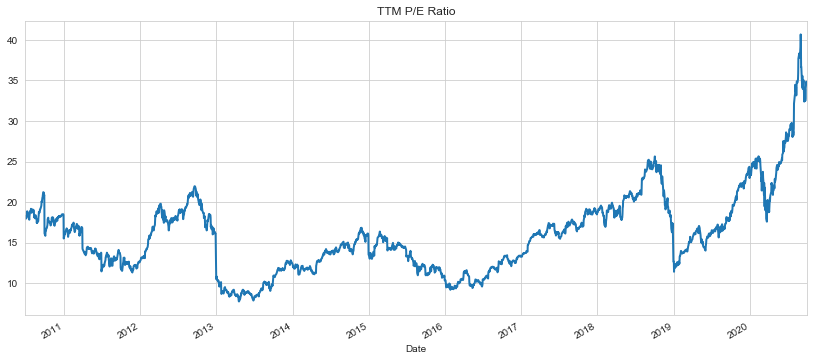

In [46]:
pe['P/E Ratio'].plot(lw=2, figsize=(14, 6), title='TTM P/E Ratio');

In [47]:
# pe = aapl_stock.Close.to_frame('price').join(eps.to_frame('eps'))
# pe = pe.fillna(method='ffill').dropna()
# pe['P/E Ratio'] = pe.price.div(pe.eps)
# pe['P/E Ratio'].plot(lw=2, figsize=(14, 6), title='TTM P/E Ratio');

In [48]:
pe.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2581 entries, 2010-06-30 to 2020-09-29
Data columns (total 3 columns):
price        2581 non-null float64
eps          2581 non-null float64
P/E Ratio    2581 non-null float64
dtypes: float64(3)
memory usage: 80.7 KB


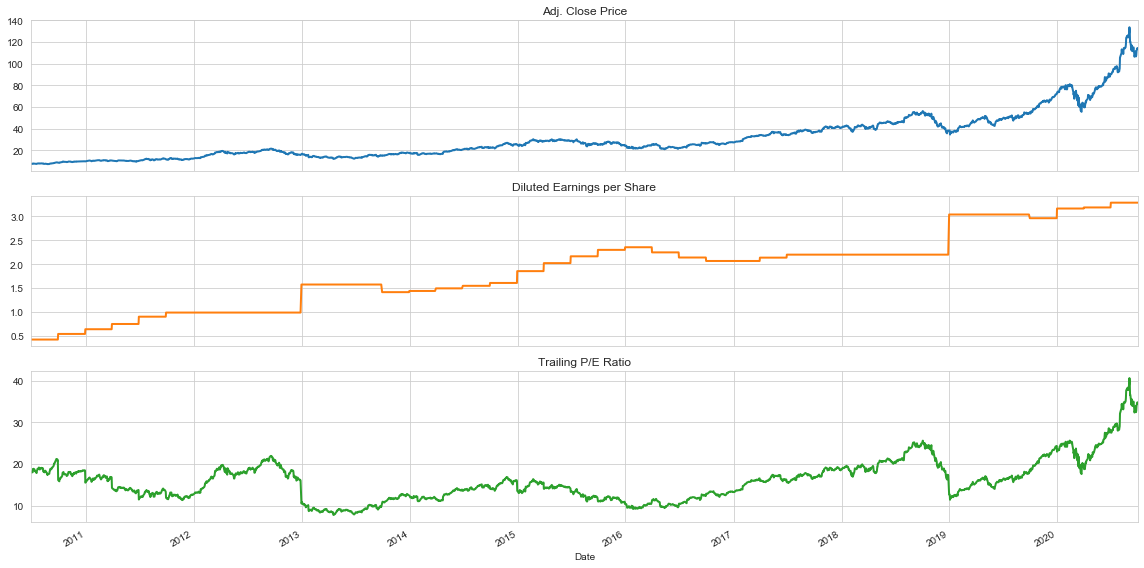

In [49]:
axes = pe.plot(subplots=True, figsize=(16,8), legend=False, lw=2)
axes[0].set_title('Adj. Close Price')
axes[1].set_title('Diluted Earnings per Share')
axes[2].set_title('Trailing P/E Ratio')
plt.tight_layout();

## Explore Additional Fields

The field `tag` references values defined in the taxonomy:

In [50]:
aapl_nums.tag.value_counts()

CashAndCashEquivalentsAtCarryingValue                                                                                1198
OperatingIncomeLoss                                                                                                  1013
SalesRevenueNet                                                                                                      1010
AvailableForSaleSecuritiesAmortizedCost                                                                               906
AvailableForSaleSecuritiesNoncurrent                                                                                  836
                                                                                                                     ... 
ShareBasedCompensationArrangementByShareBasedPaymentAwardPeriodOfTimeOptionsBecomeExercisable                           1
SharebasedCompensationArrangementbySharebasedPaymentAwardOptionsNumberofSharesofCommonSharesAwardedUponSettlement       1
LesseeOperatingLeaseLiab

We can select values of interest and track their value or use them as inputs to compute fundamental metrics like the Dividend/Share ratio.

### Dividends per Share

In [51]:
fields = ['EarningsPerShareDiluted',
          'PaymentsOfDividendsCommonStock',
          'WeightedAverageNumberOfDilutedSharesOutstanding',
          'OperatingIncomeLoss',
          'NetIncomeLoss',
          'GrossProfit']

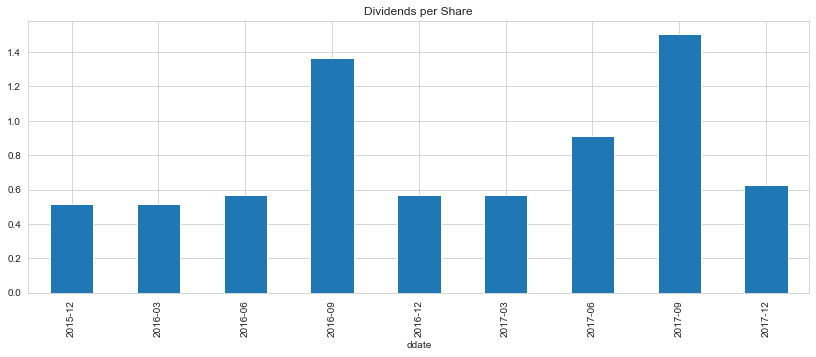

In [52]:
dividends = (aapl_nums
             .loc[aapl_nums.tag == 'PaymentsOfDividendsCommonStock', ['ddate', 'value']]
             .groupby('ddate')
             .mean())
shares = (aapl_nums
          .loc[aapl_nums.tag == 'WeightedAverageNumberOfDilutedSharesOutstanding', ['ddate', 'value']]
          .drop_duplicates()
          .groupby('ddate')
          .mean())
df = dividends.div(shares).dropna()
ax = df.plot.bar(figsize=(14, 5), title='Dividends per Share', legend=False)
ax.xaxis.set_major_formatter(mticker.FixedFormatter(df.index.strftime('%Y-%m')))

## Bonus: Textual Information

In [53]:
txt = pd.read_parquet(data_path / '2016_2' / 'parquet' /  'txt.parquet')

AAPL's adsh is not avaialble in the txt file but you can obtain notes from the financial statesments here:

In [54]:
txt.head()

,adsh,tag,version,ddate,qtrs,iprx,lang,dcml,durp,datp,dimh,dimn,coreg,escaped,srclen,txtlen,footnote,footlen,context,value
0,0000799288-16-000122,AmendmentFlag,dei/2014,20160131,4,0,en-US,32767,0.021918,2.0,0x00000000,0,None,0,5,5,None,0,FD2015Q4YTD,false
1,0000799288-16-000122,CurrentFiscalYearEndDate,dei/2014,20160131,4,0,en-US,32767,0.021918,2.0,0x00000000,0,None,0,7,7,None,0,FD2015Q4YTD,--01-29
2,0000799288-16-000122,DocumentFiscalPeriodFocus,dei/2014,20160131,4,0,en-US,32767,0.021918,2.0,0x00000000,0,None,0,2,2,None,0,FD2015Q4YTD,FY
3,0000799288-16-000122,DocumentFiscalYearFocus,dei/2014,20160131,4,0,en-US,32767,0.021918,2.0,0x00000000,0,None,0,4,4,None,0,FD2015Q4YTD,2015
4,0000799288-16-000122,DocumentPeriodEndDate,dei/2014,20160131,4,0,en-US,32767,0.021918,2.0,0x00000000,0,None,0,10,10,None,0,FD2015Q4YTD,2016-01-29
